## **Information.**

**<span style="color:red">Task:</span>** to forecast the electricity demands of two American cities. 


**Columns:**
* date – date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1;
* day – day of the week (1-7);
* period – time of the measurement (1-48) in half hour intervals over 24 hours (normalized between 0 and 1);
* nswprice – New South Wales electricity price (normalized between 0 and 1);
* nswdemand – New South Wales electricity demand (normalized between 0 and 1);
* vicprice – Victoria electricity price (normalized between 0 and 1);
* vicdemand – Victoria electricity demand (normalized between 0 and 1);
* transfer – scheduled electricity transfer between both states (normalized between 0 and 1);
* class – the change of the price (up or down) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label.

## **Necessary libraries.**

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, log_loss
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electricity-demands/electricity.csv


## **Dataset downloading.**

In [3]:
df = pd.read_csv("/kaggle/input/electricity-demands/electricity.csv")

## **Analysis.**

In [4]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  object 
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  object 
dtypes: float64(7), object(2)
memory usage: 3.1+ MB


The dataset has 7 decimal columns and 2 string columns, 9 columns in total.

In [6]:
df_len = len(df) 
df_len

45312

The length of the dataset is 45,312.

In [7]:
df.isna().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

No data leaks.

## **Solution.**

#### **Data Preparation.**

Target encoding is needed to indicate the variable that we are trying to predict. In this case, this variable is <span style="color:red">'class'</span>.

In [8]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

Convert the date column to datetime format and transform it to epoch timestamps.

In [9]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: x.timestamp())

Encode categorical data (e.g., the day column).

In [10]:
df['day'] = le.fit_transform(df['day'])

Separate features (X) and target (y).

In [11]:
X = df[['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']].values
y = df['class'].values

Ensure all feature data is numeric.

In [12]:
X = X.astype('float32')

Split the dataset.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Model.**

#### **XGBClassifier.**

In [14]:
# XGBoost training.
model = xgb.XGBClassifier(
    n_estimators=4000, 
    learning_rate=0.04, 
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False,
    verbosity=1
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = (predictions_proba > 0.5).astype(int)


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.847843
1  Precision  0.838263
2     Recall  0.797779
3   F1-Score  0.817520
4        MSE  0.152157
5    Entropy  0.348514


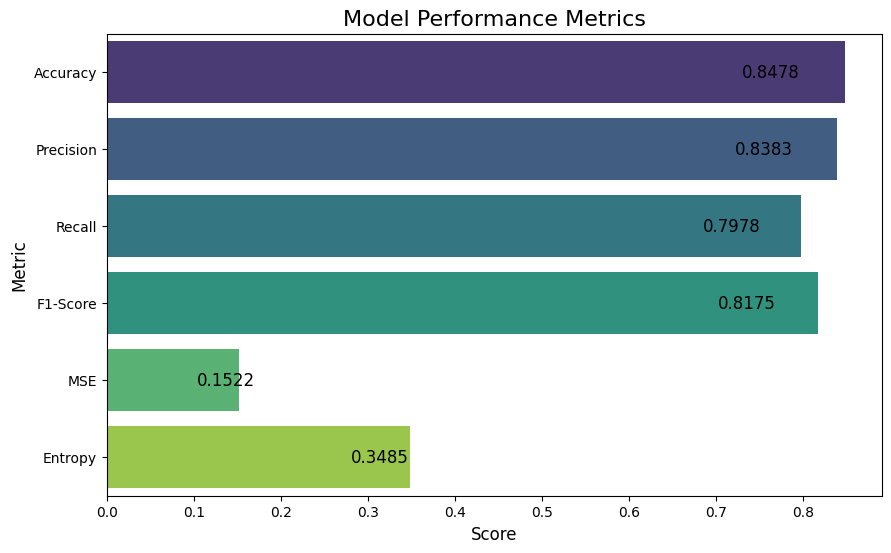

In [16]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
entropy = log_loss(y_test, predictions_proba)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'Entropy'],
    'Score': [accuracy, precision, recall, f1, mse, entropy]
}
df_metrics = pd.DataFrame(metrics)

print("\nModel Performance Metrics:")
print(df_metrics)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Score', y='Metric', data=df_metrics, palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Metric', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}', 
                (p.get_x() + p.get_width() * 0.9, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')
plt.show()

Feature Importance.

In [17]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: x.timestamp())

df['day'] = le.fit_transform(df['day'])

X = df[['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

Feature Scores.

In [18]:
feature_importances = model.feature_importances_
feature_names = X.columns

Scores to DF.

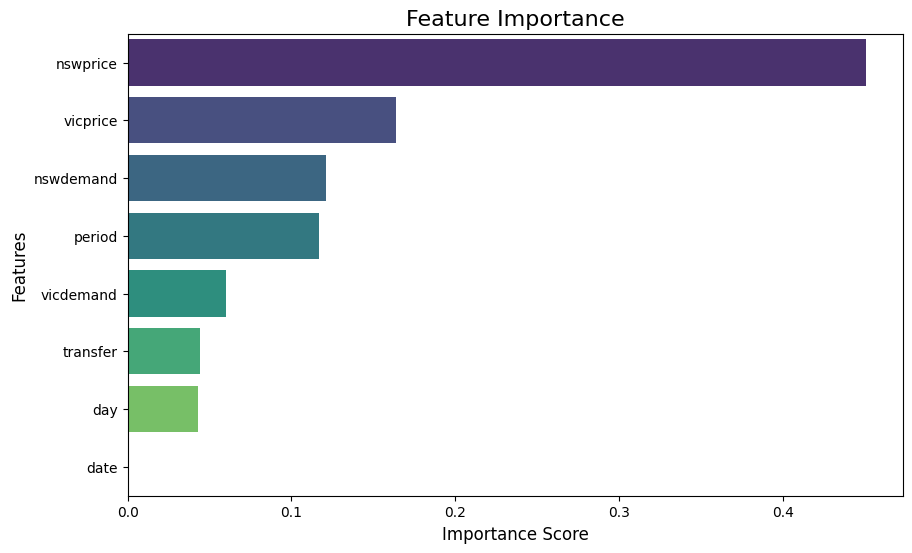

Feature Importances:
     Feature  Importance
3   nswprice    0.450706
5   vicprice    0.164086
4  nswdemand    0.121132
2     period    0.117106
6  vicdemand    0.060183
7   transfer    0.044083
1        day    0.042705
0       date    0.000000


In [19]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

print("Feature Importances:")
print(importance_df)

#### **CatBoostClassifier.**

In [20]:
# CatBoost training.
model = CatBoostClassifier(iterations=4000, learning_rate=0.04, objective='Logloss', eval_metric='AUC', task_type='CPU', verbose=100)
model.fit(X_train, y_train)

0:	total: 58.2ms	remaining: 3m 52s
100:	total: 812ms	remaining: 31.3s
200:	total: 1.62s	remaining: 30.7s
300:	total: 2.38s	remaining: 29.3s
400:	total: 3.14s	remaining: 28.2s
500:	total: 3.88s	remaining: 27.1s
600:	total: 4.63s	remaining: 26.2s
700:	total: 5.38s	remaining: 25.3s
800:	total: 6.13s	remaining: 24.5s
900:	total: 6.88s	remaining: 23.6s
1000:	total: 7.62s	remaining: 22.8s
1100:	total: 8.37s	remaining: 22s
1200:	total: 9.12s	remaining: 21.2s
1300:	total: 9.86s	remaining: 20.5s
1400:	total: 10.6s	remaining: 19.7s
1500:	total: 11.4s	remaining: 19s
1600:	total: 12.2s	remaining: 18.2s
1700:	total: 12.9s	remaining: 17.4s
1800:	total: 13.7s	remaining: 16.7s
1900:	total: 14.4s	remaining: 15.9s
2000:	total: 15.1s	remaining: 15.1s
2100:	total: 15.9s	remaining: 14.4s
2200:	total: 16.9s	remaining: 13.8s
2300:	total: 17.8s	remaining: 13.1s
2400:	total: 18.6s	remaining: 12.4s
2500:	total: 19.3s	remaining: 11.6s
2600:	total: 20.1s	remaining: 10.8s
2700:	total: 20.9s	remaining: 10s
2800:	to

In [21]:
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = (predictions_proba > 0.5).astype(int)


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.844312
1  Precision  0.837401
2     Recall  0.788740
3   F1-Score  0.812342
4        MSE  0.155688
5    Entropy  0.350089


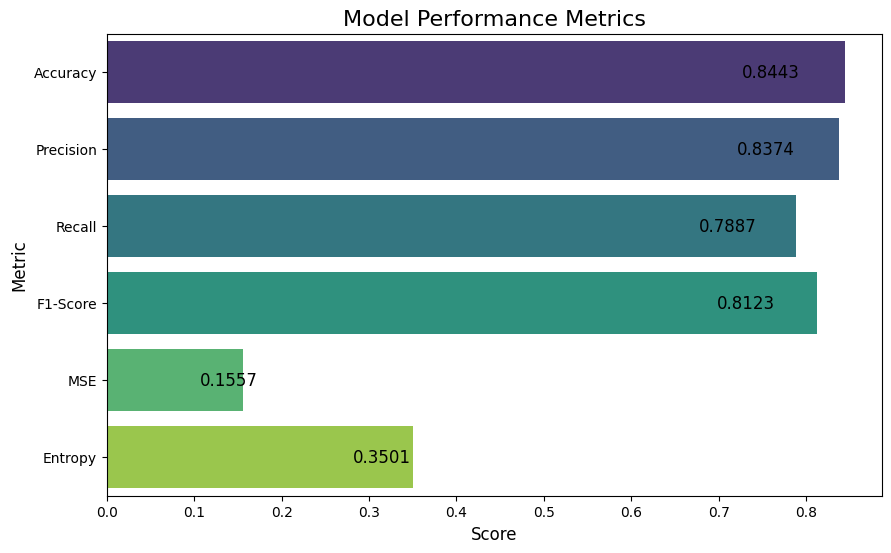

In [22]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
entropy = log_loss(y_test, predictions_proba)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'Entropy'],
    'Score': [accuracy, precision, recall, f1, mse, entropy]
}
df_metrics = pd.DataFrame(metrics)

print("\nModel Performance Metrics:")
print(df_metrics)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Score', y='Metric', data=df_metrics, palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Metric', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}', 
                (p.get_x() + p.get_width() * 0.9, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')
plt.show()

#### **RandomForestClassifier.**

In [23]:
# RandomForestClassifier training.
model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

In [24]:
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = (predictions_proba > 0.5).astype(int)


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.805362
1  Precision  0.827126
2     Recall  0.688275
3   F1-Score  0.751339
4        MSE  0.194638
5    Entropy  0.421831


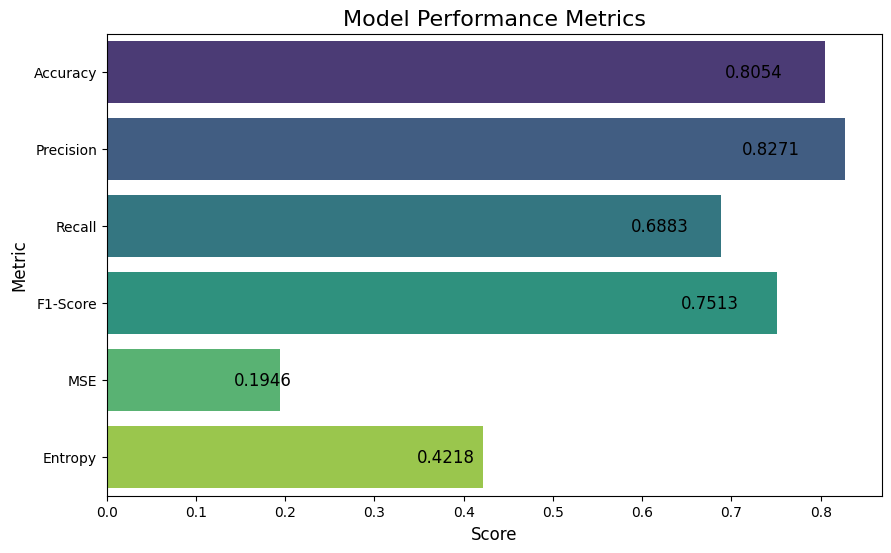

In [25]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
entropy = log_loss(y_test, predictions_proba)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'Entropy'],
    'Score': [accuracy, precision, recall, f1, mse, entropy]
}
df_metrics = pd.DataFrame(metrics)

print("\nModel Performance Metrics:")
print(df_metrics)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Score', y='Metric', data=df_metrics, palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Metric', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}', 
                (p.get_x() + p.get_width() * 0.9, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')
plt.show()